<a href="https://colab.research.google.com/github/abrarum/bezierobjdet/blob/main/TESTS/workspace/mobile/index2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
#%reset -f

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_absolute_error
from scipy.optimize import linear_sum_assignment

import numpy as np
from numpy.random import rand, randint
from numpy import dot
from numpy.linalg import norm

import matplotlib.pyplot as plt
import os
import fnmatch
import pandas as pd

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
#import matplotlib
#print('matplotlib: {}'.format(matplotlib.__version__))

from PIL import Image, ImageDraw
from keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, UpSampling2D, ZeroPadding2D, Flatten, Conv1D, Conv2D, Conv3D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from keras.layers.merge import add, concatenate

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


***
# GLOBALS AND PATHS

In [2]:
image_width = image_height = 400
gridcell = 10
training_mode = False
learning_rate = 0.1 # 0.1, 0.05, 0.01

# -------- PATHS --------

# 0 -- artificial // 1 -- 2CP // 2 -- 3CP
MODE = 1

# TRAINING

IMAGES = ["./datasets/artificial/train", "./datasets/2CP/train", "./datasets/3CP/train"]
LABELS = ["./datasets/artificial/train.csv", "./datasets/2CP/train.csv", "./datasets/3CP/train.csv"]

# TESTING
TEST_IMAGES = ["./images/multi_lines/test", "./datasets/2CP/test", "./datasets/3CP/test"]
TEST_LABELS = ["./images/multi_lines/test.csv", "./datasets/2CP/test.csv", "./datasets/3CP/test.csv"]

MODEL = ["./custom_models/artificial_model", "./custom_models/2CP_model", "./custom_models/3CP_model"]

########### --- TRAINING ---

# IMAGE DATASET
image_root = IMAGES[MODE]
total_files = fnmatch.filter(os.listdir(image_root), '*.png')

# LABELS
csv_path = LABELS[MODE]
train_df=pd.read_csv(csv_path, sep=',',header=0)

########### --- TESTING --- 

# IMAGE DATASET
test_image_root = TEST_IMAGES[MODE]
test_total_files = fnmatch.filter(os.listdir(test_image_root), '*.png')

# LABELS
test_csv_path = TEST_LABELS[MODE]
test_df=pd.read_csv(test_csv_path, sep=',',header=0)


# MODEL
model_path = MODEL[MODE]

***
# GATHER DATA

In [3]:
def image_read(fn, test=False):
    ''' read file_name, converts it in to RGB and return an image array '''
    link = os.path.join(image_root if test == False else test_image_root, fn)
    image = Image.open(link).convert('RGB')
    im = np.asarray(image)
    return im

def reorder_coords(coords):
    '''Reorders points so that the first point is closest to (0,0)'''
    coords = list(coords) # copy
    for i,line in enumerate(coords):
        if(MODE != 2):
            x0,x1, y0,y1 = line
            if (x0**2+y0**2) > (x1**2+y1**2):
                x0,x1, y0,y1 = x1,x0, y1,y0
            coords[i] = [x0,x1,y0,y1]
        else:
            x0,x1,x2, y0,y1,y2 = line
            if (x0**2+y0**2) > (x1**2+y1**2) > (x2**2+y2**2):
                x0,x1,x2, y0,y1,y2 = x2,x1,x0, y2,y1,y0
            coords[i] = [x0,x1,x2,y0,y1,y2]
    return coords

def getInfo(fn, test=False):
    ''' returns image, gtruth pixels (gridcell x gridcell x 1) and coordinates (gridcell x gricell x 4) '''
    image = image_read(fn+".png", test)
    
    df = train_df if test == False else test_df
        
    rows = np.where(df.filename==fn)
    
    class_id = df["class"][rows[0][0]]
    coords = []
    
    for i in rows[0]:
        c_id = []
        c_coord = []
        
        if (MODE != 2):
            c_coord.append(df.xmin[i])
            c_coord.append(df.xmax[i])
            #the Y coordinate axis in the annotations starts at bottom
            #inverting
            c_coord.append(image_height - df.ymin[i])
            c_coord.append(image_height - df.ymax[i])
            
        else:
            c_coord.append(df.x_0[i])
            c_coord.append(df.x_1[i])
            c_coord.append(df.x_2[i])
            #the Y coordinate axis in the annotations starts at bottom
            #inverting
            c_coord.append(image_height - df.y_0[i])
            c_coord.append(image_height - df.y_1[i])
            c_coord.append(image_height - df.y_2[i])
        
        coords.append(c_coord)
        c_id = []
    coords = reorder_coords(coords)
    return image, class_id, coords

***
# PLOT LINE

In [4]:
def plot_line(image, pred_coords, norm=False):
    ''' create a canvas image on an axis incorp. image and coordinates into 1. '''
    
    #correct image size, no padding
    figo = Figure(figsize=(2,2), dpi=image_height/2, tight_layout={'pad':0})

    canvas = FigureCanvasAgg(figo)

    # plot
    ax_r = figo.add_subplot()
    if norm:
        image *= 255.
        image = image.astype(np.uint8)
    
    ax_r.imshow(image)
    #set plot limits in case coords as out-of-bounds
    ax_r.set_ylim(image_height,0)
    ax_r.set_xlim(0,image_width)
    
    for i in pred_coords:
        if(MODE != 2):
            xmin, xmax, ymin, ymax = i
            ax_r.plot([xmin, xmax], [ymin, ymax], 'r+', linestyle='dotted', label='prediction')
        else:
            x0,x1,x2, y0,y1,y2 = i
            ax_r.plot([x0,x1,x2], [y0,y1,y2], 'r+', linestyle='dotted', label='prediction')
    ax_r.set_axis_off()

    canvas.draw()

    buf = canvas.buffer_rgba()
    # ... convert to a NumPy array ...
    X = np.asarray(buf)
    # ... and pass it to PIL.
    im = Image.fromarray(X)

    return im

def randlGen():
    ''' random image generator from data file_name '''
    rElem = np.random.choice(total_files)
    rElem = rElem[0:-4]
    return rElem

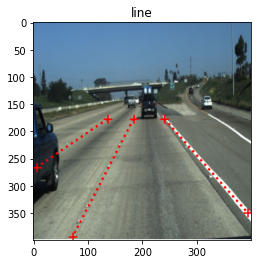

In [5]:
# testing getInfo and plot_line
image, class_id, pred_coords = getInfo(randlGen())

image = plot_line(image, pred_coords,norm=False)
plt.imshow(image)
plt.title("line")
#plt.tight_layout(pad=0)
plt.show()

***
# Non Max Suppression

In [6]:
def similarity(a, b):
    mae = mean_absolute_error(a, b)
    sim = 1.0 /  mae if mae else 0
    return sim
    
def sort_by_score(line_pred, cls_pred):
    score_indices = np.argsort(cls_pred, axis=0)
    sorted_lines = np.take_along_axis(line_pred, score_indices, axis=0)
    return sorted_lines

def line_nms(lines, scores, l_threshold = 0.9):
    selected_lines = []
    filtered_lines = []

    sorted_lines = sort_by_score(lines, scores)
    for line0 in sorted_lines:
        if any((line0 == p).all() for p in filtered_lines):
            continue

        selected_lines.append(line0)    

        for line1 in lines:
            if similarity(line0, line1) > l_threshold:
                filtered_lines.append(line1)
    return selected_lines

***
# Pixel gTruth and Line gTruth

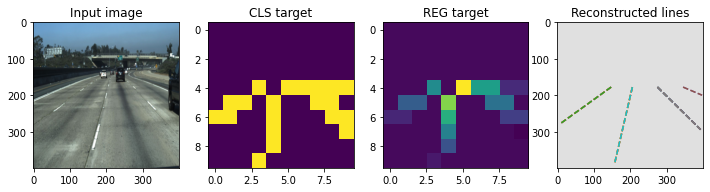

In [7]:
def point_linesegment_distance(points, line):
    #print("pts, lines::::", points, line)
    '''Computes the (approximate) distance from `points` (shape [N,2] to the line segment line (shape [2,2])'''
    direction = line[1] - line[0]
    N = 100
    points_on_line = line[0] + direction[np.newaxis] * np.linspace(0,1,N)[:,np.newaxis]
    distances      = np.sqrt(((points[np.newaxis] - points_on_line[:, np.newaxis])**2).sum(-1))
    return distances.min(axis=0)

def generate_cellcenters(gridsize):
    cellcenters = np.stack(np.meshgrid(*[np.arange(gridsize)]*2, indexing='ij'), axis=-1)  #shape: 10,10,2
    cellcenters = (cellcenters+0.5) / gridsize  #normalized coordinates 0...1
    return cellcenters

def encode_lines(lines, distance_threshold=0.05):
    '''Encodes a set of lines into a classification and regression map/target'''
    c_targets = []  #classification targets (one per line)
    r_targets = []  #regression targets (one per line)
    
    for xxyy in lines:
        x1, x2, y1, y2 = xxyy
        line = np.array( [[y1,x1],[y2,x2]] ) / (image_height, image_width) #normalized coordinates 0...1
        
        cellcenters = generate_cellcenters(gridcell)
        distances   = point_linesegment_distance(cellcenters.reshape(-1, 2), line).reshape(gridcell,gridcell)
        
        c_targets  += [distances < distance_threshold]
        r_targets  += [line - cellcenters[...,np.newaxis,:]]
    
    #combine the per-line targets to a single per-image target
    c_target = np.max(c_targets, axis=0)*1.0
    #for each gridcell select the regression target that is active in c_target
    #NOTE: this is not perfect for overlapping lines
    r_target = np.take_along_axis(np.array(r_targets), np.argmax(c_targets, axis=0)[None,...,None,None], axis=0)[0]
    #zero out the c_target is inactive (not really needed, only for visualization)
    r_target = r_target * c_target[...,None,None]
        
    return c_target[...,np.newaxis], r_target.reshape(gridcell,gridcell,4)
    
def decode_lines(c_map, r_map, c_threshold=0.6, l_threshold=0.9, nms=False):
    '''Decodes a classification and regression map into a set of lines (without NMS)'''
    cellcenters = cellcenters = generate_cellcenters(gridcell)
    thresholded = (c_map[...,0] > c_threshold)
    thresholded_scores = c_map[c_map>c_threshold]
    expanded_scores = np.expand_dims(thresholded_scores, axis=-1)
    
    positive_cell_indices = np.stack( thresholded.nonzero(), axis=-1 )
    positive_cell_centers = cellcenters[thresholded]
    positive_reg          = r_map[thresholded]
    
    lines  = np.concatenate([positive_cell_centers]*2, axis=-1) + positive_reg
    lines *= [image_height, image_width]*2   #normalized -> pixel values
    lines_xxyy = np.concatenate([lines[...,1::2], lines[...,0::2]], axis=-1)
    
    # Apply NMS
    lines_xxyy = line_nms(lines_xxyy, expanded_scores, l_threshold) if nms == True else lines_xxyy
    
    return lines_xxyy

image, class_id, coords = getInfo('li_194')

plt.figure(0, (12,7))
plt.subplot(141); plt.imshow( image ); plt.title('Input image');
plt.subplot(142); plt.imshow( encode_lines(coords)[0][...,0] ); plt.title('CLS target');
plt.subplot(143); plt.imshow( encode_lines(coords)[1][...,2] ); plt.title('REG target');
plt.subplot(144); plt.imshow( np.ones_like(image)*224 ); plt.title('Reconstructed lines')
for line in decode_lines( *encode_lines(coords) ):
    plt.plot(line[:2], line[2:], '--')

***
# DATA GEN

In [8]:
batch_size = 32

def regression_weight_map(cls_target):
    '''Creates a weight map for the regression target.
       The weight map is 1.0 where the classification target is not zero.
       Shape=(B,H,W)  (no channel dimension as required by the loss functions)'''
    return (cls_target[...,0] > 0).astype('float32')

def data_generator(batch_size=32):
    while 1:
        permutation = np.random.permutation(len(total_files))
        for i in range(0, len(total_files), batch_size):
            images    = []
            c_targets = []
            r_targets = []
            for j in permutation[i:][:batch_size]:
                index                   = total_files[j].replace('.png','')
                image, class_id, coords = getInfo(index)
                image                   = image / np.float32(255)
                c_target, r_target      = encode_lines(coords)
                images    += [image]
                c_targets += [c_target]
                r_targets += [r_target]

            images    = np.stack(images)
            c_targets = np.stack(c_targets)
            r_targets = np.stack(r_targets)
            sample_weight = regression_weight_map(c_targets)
            yield {'image': images}, {'class_out': c_targets, 'line_out': r_targets}, {'line_out': sample_weight}
            

def test_data_generator(batch_size=32):
    while 1:
        permutation = np.random.permutation(len(test_total_files))
        for i in range(0, len(test_total_files), batch_size):
            images    = []
            class_ids = []
            coords = []
            for j in permutation[i:][:batch_size]:
                index                   = test_total_files[j].replace('.png','')
                image, class_id, coord = getInfo(index, test=True)
                image                   = image / np.float32(255)
                
                images    += [image]
                class_ids += [class_id]
                coords += [coord]
                
            images    = np.stack(images)
            yield {'image': images}, {'class_out': class_ids, 'line_out': coords}

***
# MODELLING FUNCTIONS

In [9]:
''' 8, 6 + n_filters remove 16 '''
def build_model():
    '''' model '''
    input_ = Input(shape=(image_height, image_width, 3), name='image')

    x = input_
    
    line_shape = 4 if MODE != 2 else 6

    for n_filters in [16,32, 64, 128, 256]:
      x = Conv2D(n_filters, 3, activation='relu')(x)
      x = BatchNormalization(momentum=0.9)(x)
      #x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
      #x = BatchNormalization()(x)
      x = MaxPool2D(2)(x)
    
    #x = Dropout(0.50)(x)
    #x1 = Conv2D(1, (1,1), name="class_out", activation='sigmoid')(x)
    #x2 = Conv2D(4, (1,1), name="line_out")(x)
    
    x1 = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x1 = BatchNormalization(momentum=0.9)(x1)
    x1 = Conv2D(1, (1,1), name="class_out", activation='sigmoid')(x1)
    
    x2 = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x2 = BatchNormalization(momentum=0.9)(x2)
    x2 = Conv2D(line_shape, (1,1), name="line_out")(x2)
    
    model = tf.keras.models.Model(input_, [x1,x2])
    return model

def compile_model(model):
    model.compile(
        loss={
            #from_logits=True if class_out has no activation function
            #from_logits=False if class_out has sigmoid activation
            'class_out': keras.losses.BinaryCrossentropy(from_logits=False),
            #'class_out': keras.losses.MeanAbsoluteError(),
            'line_out': 'mae'
        },
        #loss_weights={ 'class_out':1.0, 'line_out':1e-5 },
        loss_weights={ 'class_out':1.0, 'line_out':10.0 },
        #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
        metrics={
            'class_out': 'accuracy',
            #'line_out': [tf.keras.metrics.MeanAbsoluteError()]
        },
    )
    return model

def lr_schedule(epoch, lr):
  if (epoch + 1) % 10 == 0:
    lr *= 0.2
    print('new lr:', lr)
  return max(lr, 3e-7)


def model_fit(model):
    _ = model.fit(
        data_generator(batch_size),
        use_multiprocessing=True,
        workers=os.cpu_count(),
        epochs=15,
        steps_per_epoch=len(total_files) / batch_size,
        callbacks=[
                   #ShowTestImages(),
                   #tf.keras.callbacks.EarlyStopping(monitor='line_out_mean_absolute_error', patience=3, mode='max'),
                   #tf.keras.callbacks.LearningRateScheduler(lr_schedule)
        ]
    )
    model.save(model_path)
    return model

***
# TRAIN OR IMPORT MODEL

In [10]:
def get_model():
    if(training_mode == True):
        # build model
        model = build_model()
        # compile mode
        model = compile_model(model)
        # start training
        model = model_fit(model)
        # return saved model for further processing
        return model
    else:
        # import model
        model = keras.models.load_model(model_path)
        # return saved model for further processing
        return model
    
model = get_model()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 398, 398, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 398, 398, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 199, 199, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

***
**Outputs after a few epochs training**

In [11]:
_x,_y,_ = next(iter(data_generator()))
_out_cls, _out_reg = model.predict(_x['image'])

In [12]:
_x,_y,_  = next(iter(data_generator()))
_out_cls, _out_reg = model(_x['image'], training=True)  #XXX: training=True!
_out_cls = _out_cls.numpy()
_out_reg = _out_reg.numpy()

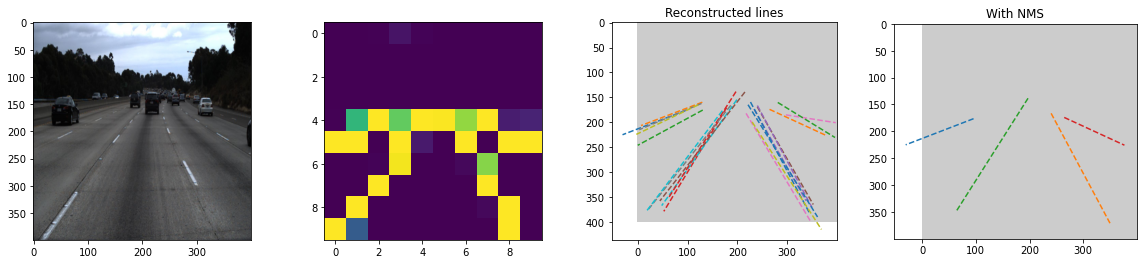

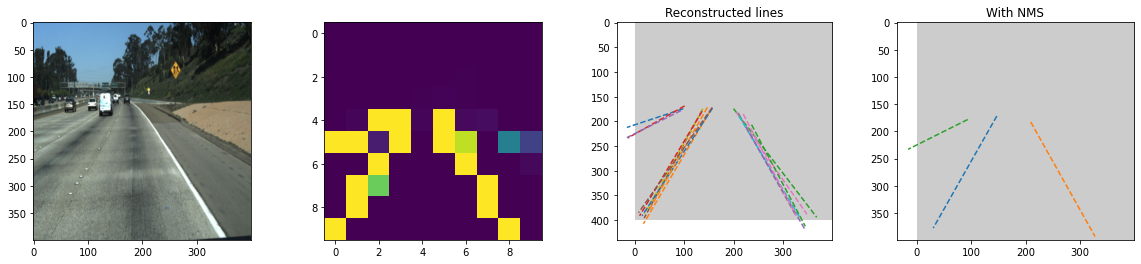

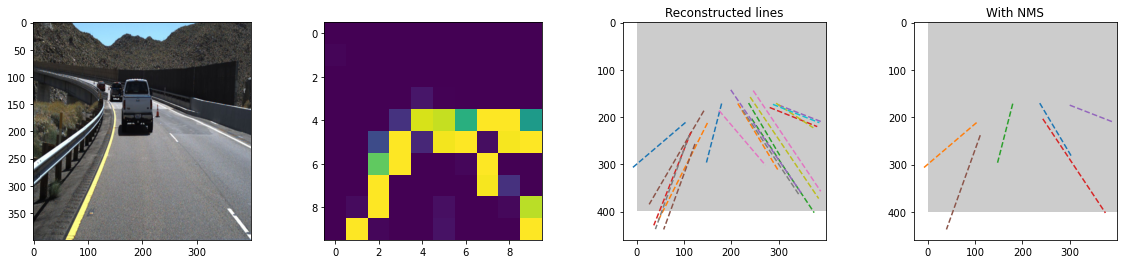

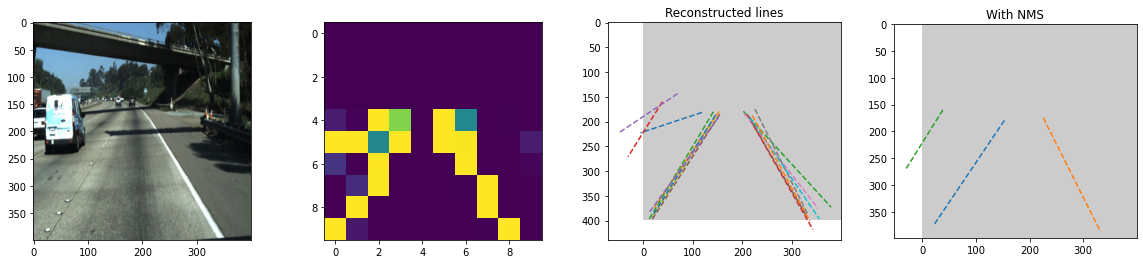

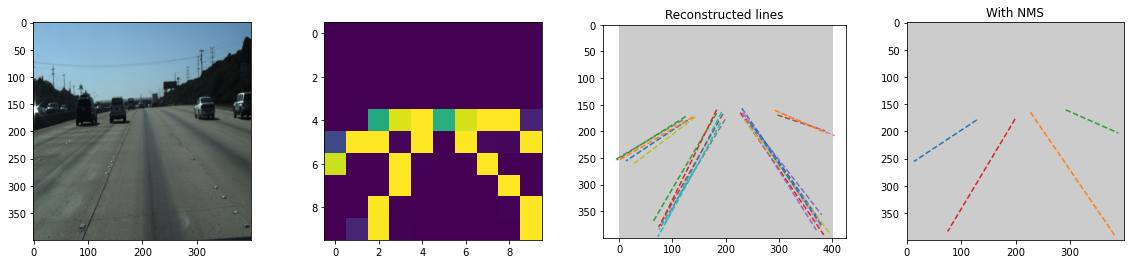

In [13]:
juncs = 2 if MODE != 2 else 3

for i in range(5):
    plt.figure(i, (20,4))
    plt.subplot(141); plt.imshow( _x['image'][i])
    plt.subplot(142); plt.imshow( _out_cls[i], vmin=0, vmax=1 )
    plt.subplot(143); plt.imshow( np.ones_like(_x['image'][i])*0.8 ); plt.title('Reconstructed lines')
    for line in decode_lines(_out_cls[i], _out_reg[i], c_threshold=0.6, nms=False):
        plt.plot(line[:juncs], line[juncs:], '--')
    plt.subplot(144); plt.imshow( np.ones_like(_x['image'][i])*0.8 ); plt.title('With NMS')
    for line in decode_lines(_out_cls[i], _out_reg[i], c_threshold=0.6, l_threshold=0.02, nms=True):
        plt.plot(line[:juncs], line[juncs:], '--')

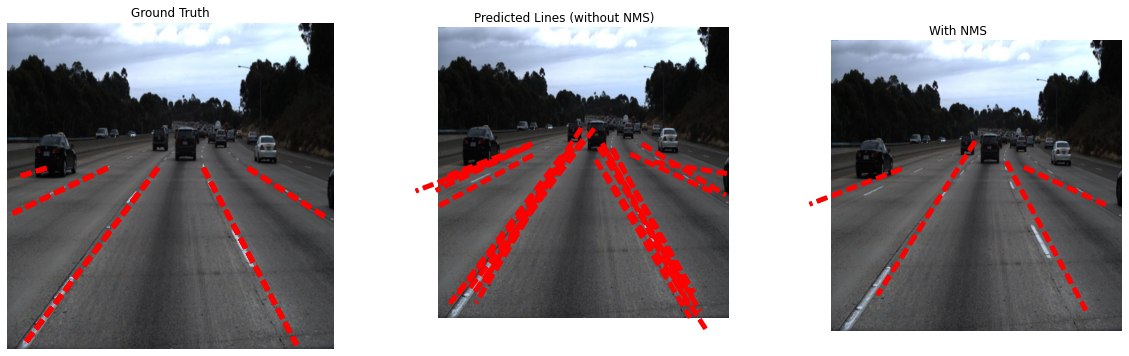

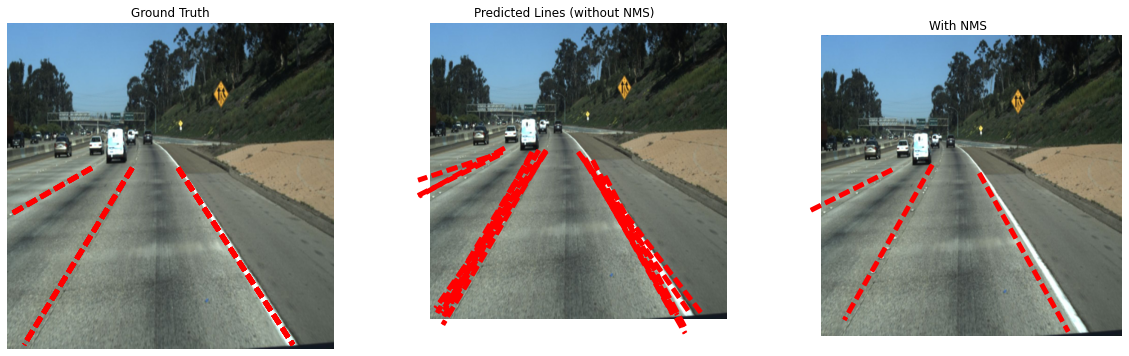

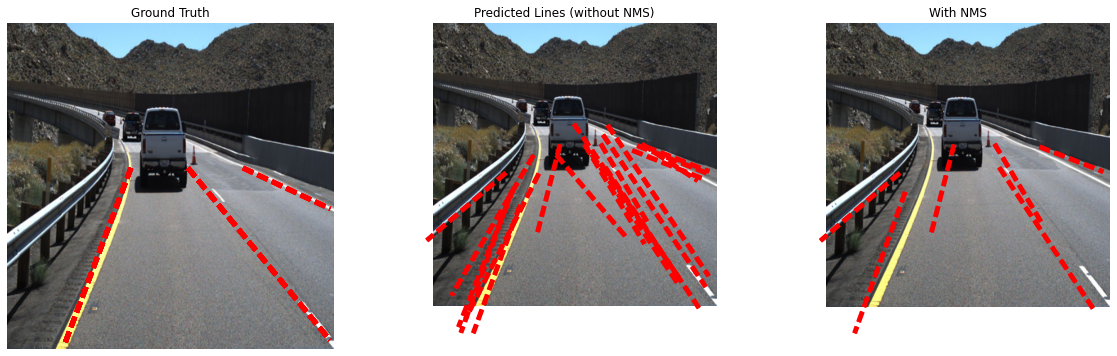

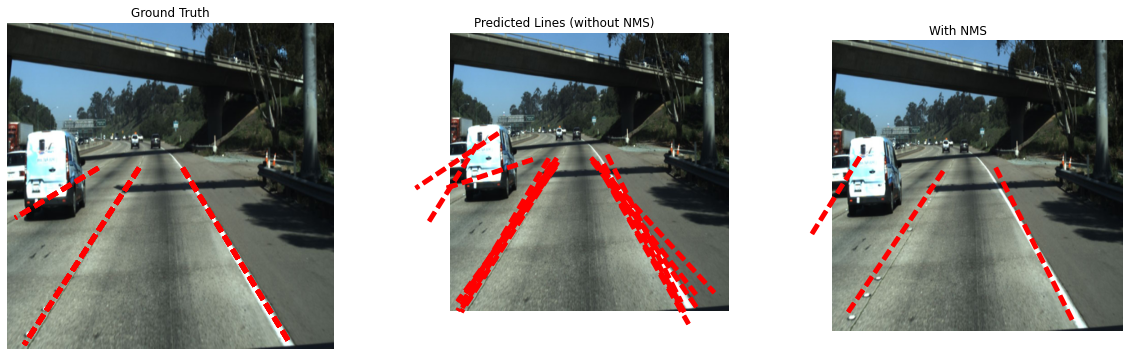

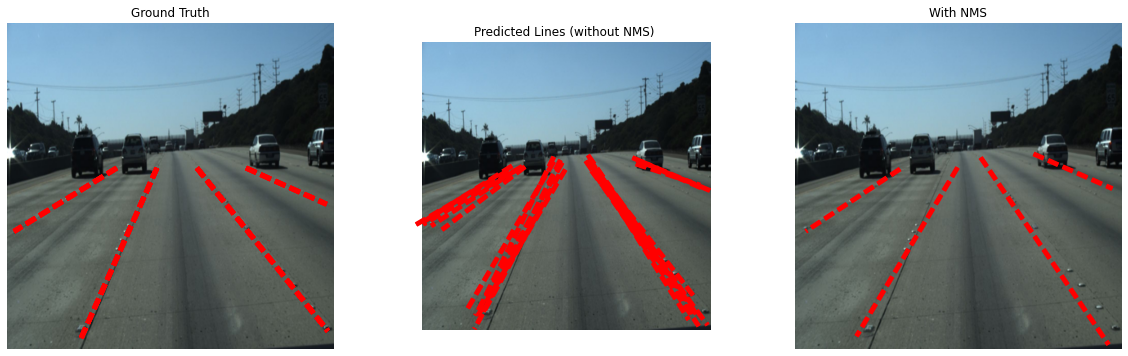

In [14]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.patheffects as pe

#plt.xkcd()
for i in range(5):
    plt.figure(i, (20,6))
    plt.subplot(131); plt.imshow(_x['image'][i], alpha=1); plt.title('Ground Truth')
    for line in decode_lines(_y['class_out'][i], _y['line_out'][i]):
        #juncs = 2 if MODE != 2 else 3
        if (MODE != 2):
            #print(line)
            plt.plot(line[:2], line[2:], '--', color="red", lw=3, path_effects=[pe.Stroke(linewidth=5), pe.Normal()])
    plt.axis('off')
    plt.subplot(132); plt.imshow(_x['image'][i], alpha=1); plt.title('Predicted Lines (without NMS)')
    for line in decode_lines(_out_cls[i], _out_reg[i], c_threshold=0.6, nms=False):
        plt.plot(line[:juncs], line[juncs:], '--', color="red", lw=3, path_effects=[pe.Stroke(linewidth=5), pe.Normal()])
    plt.axis('off')
    plt.subplot(133); plt.imshow(_x['image'][i], alpha=1); plt.title('With NMS')
    for line in decode_lines(_out_cls[i], _out_reg[i], c_threshold=0.6, l_threshold=0.02, nms=True):
        plt.plot(line[:juncs], line[juncs:], '--', color="red", lw=3, path_effects=[pe.Stroke(linewidth=5), pe.Normal()])
    plt.axis('off')

# EVALUATION

In [15]:
from scipy import stats

def mae_dist(x):
    dist = stats.median_abs_deviation(x)
    return dist

def score_frame(X, Y, threshold=60, eps=3):
    """ Scoring Prediction X on ground-truth Y by linear assignment. """
    
    D = []

    for line0 in X:
        temp = []
        for line1 in Y:
            p = mean_absolute_error(line0, line1)
            temp.append(p)
        D.append(temp)

    D = np.array(D)

    # truncate distances that violate the threshold
    D[D > threshold] = 10000

    # compute matching by solving linear assignment problem
    row_ind, col_ind = linear_sum_assignment(D, maximize=False)
    matching = D[row_ind, col_ind]
    
    # true positives are matches within the threshold
    TP = sum(matching <= threshold)

    # false negatives are missed ground truth points or matchings that violate the threshold
    FN = len(Y) - len(row_ind) + sum(matching > threshold)

    # false positives are missing predictions or matchings that violate the threshold
    FP = len(X) - len(row_ind) + sum(matching > threshold)
    
    return TP, FN, FP

In [16]:
# EVALUATION
def tp_fn_fp():
    test_x,test_y  = next(iter(test_data_generator(32)))
    test_out_cls, test_out_reg = model(test_x['image'], training=True)  #XXX: training=True!
    test_out_reg = test_out_reg.numpy()
    test_out_cls = test_out_cls.numpy()
    
    TP = []
    FN = []
    FP = []
    
    for index in range(32):
        ground_truth = test_y["line_out"][index]
        predicted_line = np.array(decode_lines(test_out_cls[index], test_out_reg[index], 
                                    c_threshold=0.6, l_threshold=0.02, nms=True))
        
        tp, fn, fp = score_frame(ground_truth, predicted_line)
        TP.append(tp)
        FN.append(fn)
        FP.append(fp)
        
    return np.sum(TP), np.sum(FN), np.sum(FP)

def find_metrics(tp, fn, fp):
    #print(tp, fn, fp)
    p = avg_precision(tp, fn, fp)
    r = avg_recall(tp, fn, fp)
    a = avg_accuracy(tp, fn, fp)
    f1 = f1_score(p, r)
    
    print("precision", p)
    print("recall", r)
    print("accuracy", a)
    print("f1 score", f1)
    
def avg_precision(tp, fn, fp):
    precision = tp / (tp + fp)
    return precision

def avg_recall(tp, fn, fp):
    recall = tp / (tp + fn)
    return recall

def avg_accuracy(tp, fn, fp):
    accuracy = (tp)/(tp + fp + fn)
    return accuracy

def f1_score(precision, recall):
    n = precision * recall
    d = precision + recall
    f1 = 2 * (n / d)
    return f1

tp, fn, fp = tp_fn_fp()

print("tp, fn, fp, y", tp, fn, fp)
find_metrics(tp, fn, fp)

tp, fn, fp, y 114 12 10
precision 0.9193548387096774
recall 0.9047619047619048
accuracy 0.8382352941176471
f1 score 0.912
